# AMAZON - Multi-label Classification (Efficient Net)

# About the Dataset

Satellite images labelled with classes of atmospheric conditions and land cover/land usage. 

Can help differentiate between human causes and natural causes forest loss. To help better understand, track and respond to deforestation around the world.

In [ ]:
import os
import zipfile
 
import pandas as pd

In [ ]:
from google.colab import files
 
uploaded = files.upload()
 
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# move kaggle.json into the folder where the API expects to find it
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 72 bytes


In [ ]:
!kaggle datasets download nikitarom/planets-dataset -p /content
!unzip -q -n /content/planets-dataset.zip -d /content
!rm /content/planets-dataset.zip

 99% 1.48G/1.50G [00:16<00:00, 75.7MB/s]
100% 1.50G/1.50G [00:16<00:00, 98.9MB/s]


In [ ]:
DATA_DIR = '/content/planet/planet'
TRAIN_DIR = DATA_DIR + '/train-jpg'
TEST_DIR =  DATA_DIR + '/test-jpg'

labels_df = pd.read_csv(DATA_DIR + '/train_classes.csv')

In [ ]:
print(labels_df.shape)
print(labels_df[:5])

(40479, 2)
  image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road


# PREVIEW IMAGES

In [ ]:
import glob
import numpy as np

import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
img = cv2.imread(TRAIN_DIR + '/train_0.jpg')
print('Image dims : {}'.format(img.shape))

Image dims : (256, 256, 3)


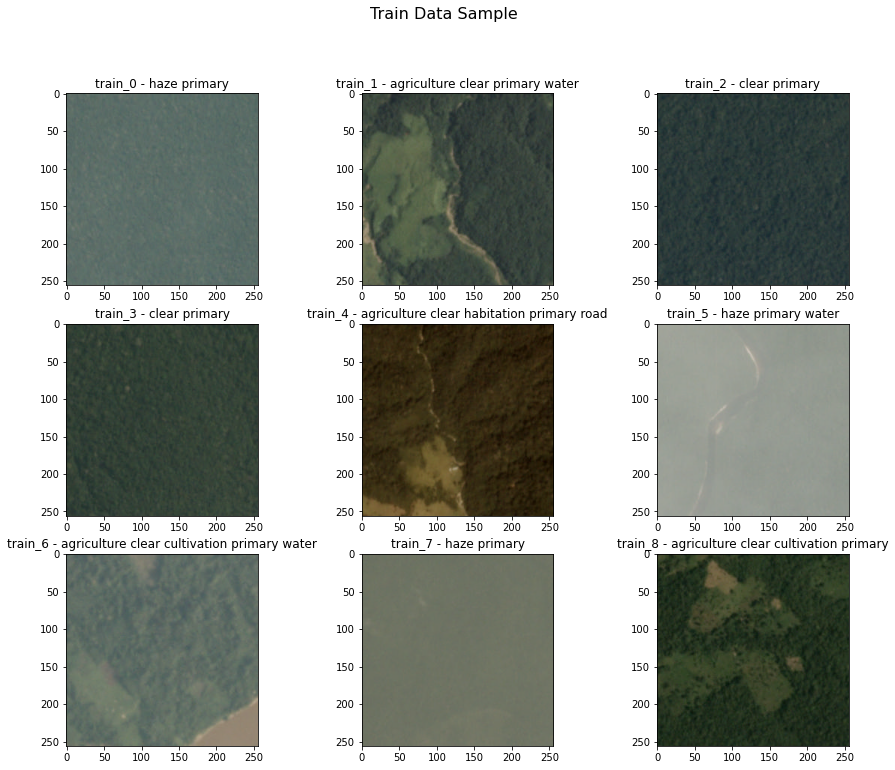

In [ ]:
fig = plt.figure(figsize=(15,12))
rows = 3
columns = 3

for i in range(9):
  path = TRAIN_DIR + '/train_' + str(i) + '.jpg'
  img = plt.imread(path)
  title = os.path.splitext(os.path.basename(path))[0] + ' - ' + labels_df['tags'][i]
  plt.subplot(rows, columns, i+1)
  plt.imshow(img)
  plt.title(title)
  if i == rows*columns-1:
    plt.suptitle('Train Data Sample', fontsize=16)

# INSPECT LABELS

In [ ]:
from itertools import chain

In [ ]:
labels_list = list(chain.from_iterable([tags.split(' ') for tags in labels_df['tags'].values]))     #labels are space-delimited
print('Total number of images : {}'.format(labels_df.shape[0]))
print('Total number of labels : {}'.format(len(labels_list)))

label_set = set(labels_list) 
print('Total number of unique labels : {}'.format(len(label_set)))
print('Average number of labels per image : {}'.format(len(labels_list)/len(labels_df['tags'])))

Total number of images : 40479
Total number of labels : 116278
Total number of unique labels : 17
Average number of labels per image : 2.8725511993873365


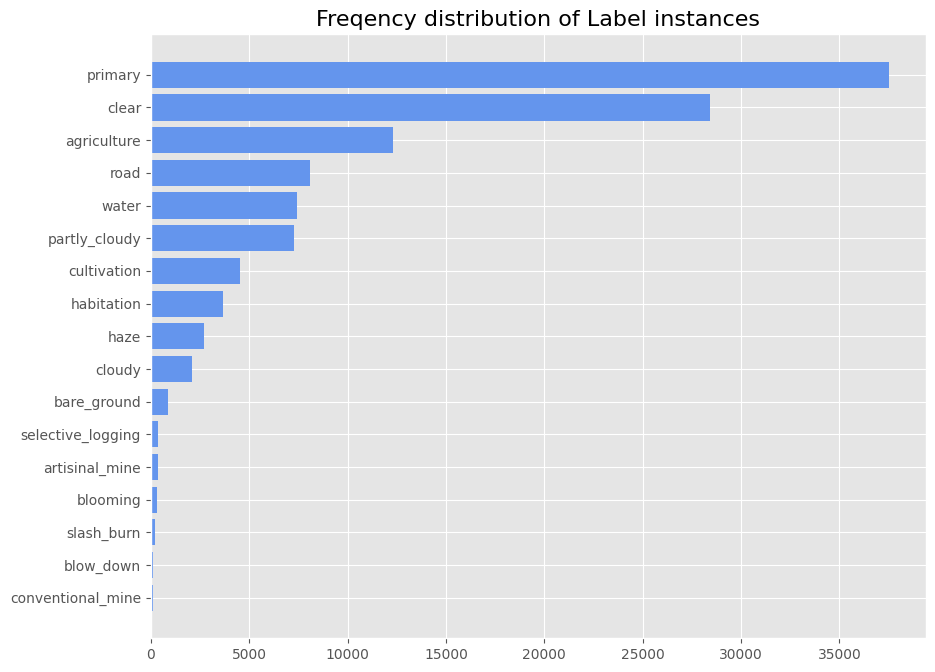

In [ ]:
labels_series = pd.Series(labels_list).value_counts(sort=True, ascending=True) #sort by frequency

plt.style.use('ggplot')     #/'default'
fig = plt.figure(figsize=(10, 8), dpi=100)
plt.barh(labels_series.index, labels_series, color='cornflowerblue')
plt.title('Freqency distribution of Label instances', fontsize=16)
fig.show()

# CO-OCCURENCE MATRIX

In [ ]:
import numpy as np
import seaborn as sns

In [ ]:
unique_labels_sorted = labels_series.index     

matrix = np.zeros((len(unique_labels_sorted), len(unique_labels_sorted)))
tags_list = [tags.split(' ') for tags in labels_df['tags'].values]

for i, label in enumerate(unique_labels_sorted):
  for i2, label2 in enumerate(unique_labels_sorted):
    if label2 != label:
      c = 0
      for tag in tags_list:
        if label in tag:
          if label2 in tag:
            c += 1
      matrix[i, i2] = c/len(tags_list)

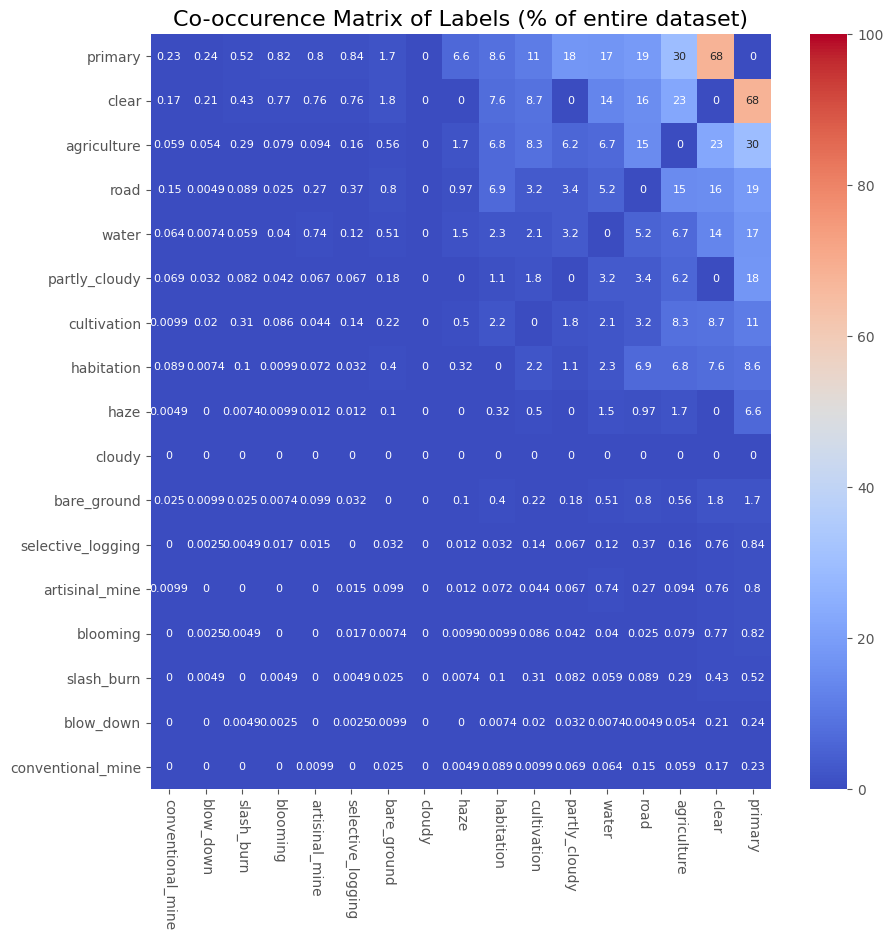

In [ ]:
plt.figure(figsize=(10,10), dpi=100)

ax = sns.heatmap(matrix*100, xticklabels=list(unique_labels_sorted), yticklabels=list(unique_labels_sorted), annot = True, annot_kws={'size':8}, fmt='.2g', vmin=0, vmax=100, cmap = 'coolwarm')
ax.invert_yaxis()
plt.xticks(rotation=-90)

plt.title('Co-occurence Matrix of Labels (% of entire dataset)', fontsize=16)
plt.show()

- 'cloudy' is an exclusive class
- 'partly cloudy' and 'clear' never co-occur
- 'primary' frequently co-occurs with other classes 
- difficult to interpret due to high class imbalance

In [ ]:
matrix = np.zeros((len(unique_labels_sorted), len(unique_labels_sorted)))
tags_list = [tags.split(' ') for tags in labels_df['tags'].values]

for i, label in enumerate(unique_labels_sorted):
  for i2, label2 in enumerate(unique_labels_sorted):
      c = 0
      cy = 0
      for tag in tags_list:
        if label in tag:
          cy += 1
          if label2 in tag:
            c += 1
      matrix[i2, i] = c/cy  

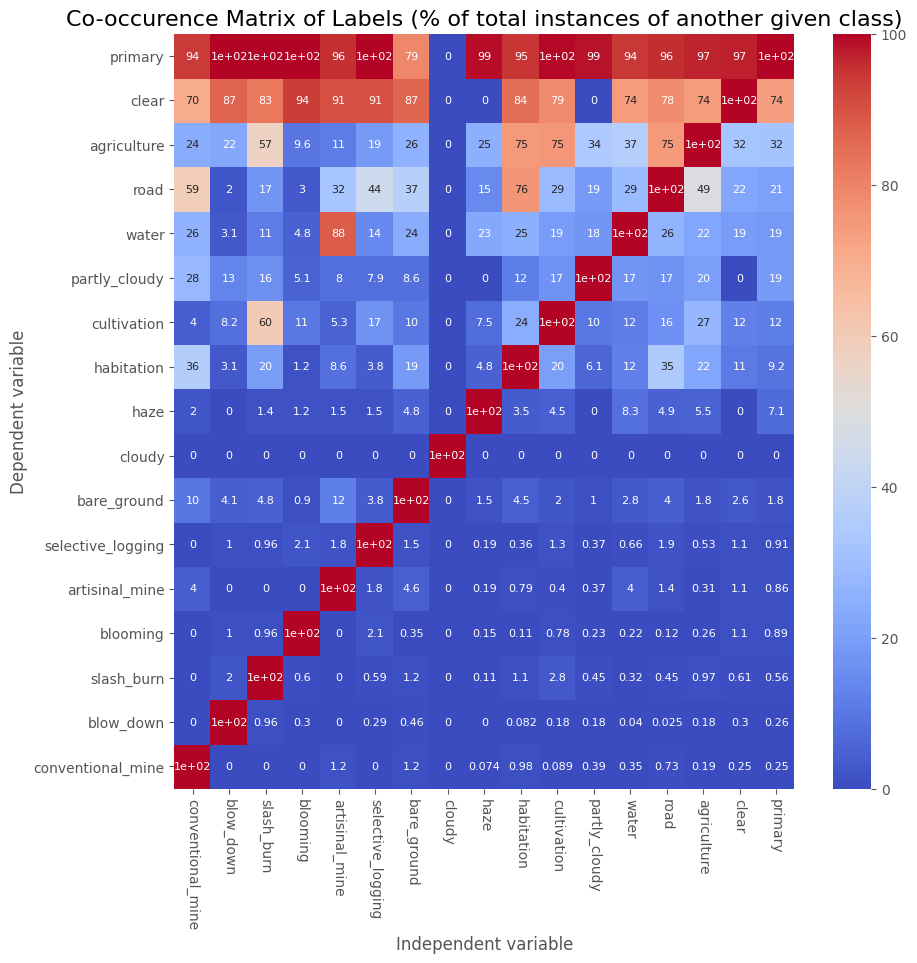

In [ ]:
plt.figure(figsize=(10,10), dpi=100)

ax = sns.heatmap(matrix*100, xticklabels=list(unique_labels_sorted), yticklabels=list(unique_labels_sorted), annot = True, annot_kws={'size':8}, fmt='.2g', vmin=0, vmax=100, cmap = 'coolwarm')
ax.invert_yaxis()
plt.xticks(rotation=-90)

plt.title('Co-occurence Matrix of Labels (% of total instances of another given class)', fontsize=16)
plt.xlabel('Independent variable')
plt.ylabel('Dependent variable')
plt.show()

# CLUSTERING / DATA VISUALIZATION WITH DIMENSIONALITY REDUCTION

In [ ]:
#import plotly.io as plt_io
import plotly.graph_objects as go
#from sklearn.decomposition import PCA
#from sklearn.manifold import TSNE
!pip install umap-learn
#!pip install --upgrade tbb
from umap import UMAP

from tqdm import tqdm

     |████████████████████████████████| 80 kB 5.2 MB/s 
     |████████████████████████████████| 1.1 MB 18.8 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76564 sha256=dca438d1ed1fe19fb3105cb28374ea45d9083272c41efb6bb4e6102fbe7b778d
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
  Created wheel for pynndescent: filename=pynndescent-0.5.4-py3-none-any.whl size=52373 sha256=a24b05edb8f3ba05433a9188520ea70b8caab8da95ac3d37eba3093bedf37c69
  Stored in directory: /root/.cache/pip/wheels/d0/5b/62/3401692ddad12324249c774c4b15ccb046946021e2b581c043
Successfully built umap-learn pynndescent


In [ ]:
# subset of images to reduce computation time
imgs = []
n_imgs = 1000
img_size = 100
img_paths = glob.glob(TRAIN_DIR + '/*.jpg')[0:n_imgs]

# image preprocessing
for img_path in tqdm(img_paths, miniters=100):
    img = plt.imread(img_path)
    img = cv2.resize(img, (img_size, img_size), cv2.INTER_LINEAR).astype('float')
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype('float')
    img = cv2.normalize(img, None, 0.0, 1.0, cv2.NORM_MINMAX)
    img = img.reshape(1, -1)      
    imgs.append(img)

# convert to np array
x = np.vstack(imgs)
print(x.shape)      # 100x100x4

100%|██████████| 1000/1000 [00:02<00:00, 393.01it/s]

(1000, 40000)


In [ ]:
## optionally standardize the data 
##standardization of a dataset is a common requirement for many machine learning estimators
##they might behave badly if the individual features do not resemble standard normally distributed data (e.g. Gaussian with 0 mean and unit variance)

#from sklearn.preprocessing import StandardScaler
#x = StandardScaler().fit_transform(x)
#print(x[0])

In [ ]:
def plot_2d(component1, component2, color='cornflowerblue', title=' '):

  fig = go.Figure(data=go.Scatter(x = component1,
                                  y = component2,
                                  mode='markers',
                                  marker=dict(size=10,      #or list/array
                                              color=color,      #or list/array      
                                              #colorscale=colorscale, 
                                              #showscale=True,
                                              opacity=0.8,
                                              line_width=1)
                                  ))
  fig.update_layout(margin=dict( l=100,r=100,b=100,t=100),width=800,height=600,title=title)                 

  fig.show()

In [ ]:
def plot_3d(component1,component2,component3, color='cornflowerblue', title=' '):

  fig = go.Figure(data=[go.Scatter3d(x=component1,
                                    y=component2,
                                    z=component3,
                                    mode='markers',
                                    marker=dict(size=8,
                                                color=color,                
                                                #colorscale=colorscale,
                                                opacity=1,
                                                line_width=1),
                                    )])
  fig.update_layout(margin=dict(l=50,r=50,b=50,t=50),width=800,height=600,title=title)

  fig.show()

In [ ]:
reducer = UMAP(n_components=3, 
               init='random', 
               random_state=0, 
               verbose=0, 
               n_neighbors=15, 
               min_dist=0.1, 
               metric='euclidean'
               #target_metric=target_metric     #unsupervised
               ) 
umap_3d = reducer.fit_transform(x)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:

The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.



In [ ]:
plot_3d(umap_3d[:,0],umap_3d[:,1],umap_3d[:,2], title='UMAP 3D')

Dimension reduction allows data visualization to identify clusters of that share similar features.

In [ ]:
reducer = UMAP(n_components=2, 
               init='random', 
               random_state=0, 
               verbose=0, 
               n_neighbors=15, 
               min_dist=0.1, 
               metric='euclidean'
               #target_metric=target_metric     #unsupervised
               ) 
umap_2d = reducer.fit_transform(x)

In [ ]:
y = []      #or use map()

for tags in labels_df['tags'].values[:n_imgs]:   
  if 'bare_ground' in tags and 'artisinal_mine' in tags:
    y.append('firebrick')
  elif 'bare_ground' in tags:
    y.append('darkorange')
  elif 'artisinal_mine' in tags:
    y.append('mediumaquamarine')  
  else:
    y.append('grey')

In [ ]:
plot_2d(umap_2d[:, 0],umap_2d[:, 1], title='UMAP 2D : bare_ground & artisinal_mine', color=y)

Individual classes may also be highlighted like so. Example shows 'bare_ground'(orange), 'artisinal_mine'(blue) and co-occurence(red).

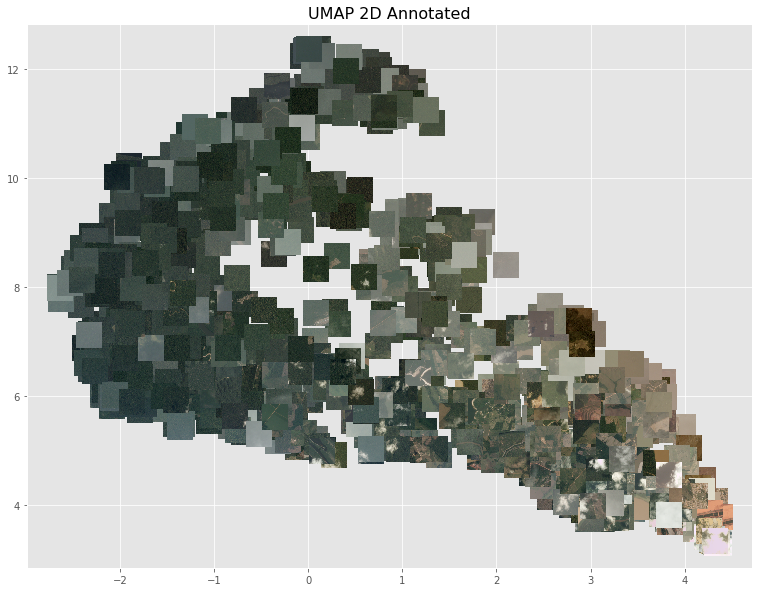

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def plot_scatter(x, y, images, ax=None, zoom=0.1):
    ax = plt.gca()
    images = [OffsetImage(image, zoom=zoom) for image in images]
    artists = []
    for x0, y0, img in zip(x, y, images):     
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

plt.figure(figsize=(13,10))
plt.title('UMAP 2D Annotated', fontsize=16)
plot_scatter(umap_2d[:, 0], umap_2d[:, 1], [plt.imread(img_paths[i]) for i in range(n_imgs)])

In [ ]:
#using images as markers in plotly requires conversion to png, displaying image as annotation on mouseover requires an additional library

# HYPERPARAMETERS

In [ ]:
input_size = 128     
split = 34000 

epochs = 8
   
batch_size = 32
num_classes = len(label_set)

# PREPROCESS LABELS AND IMAGES

In [ ]:
##tf already flattens images and OHE labels

## Alternative 1     #OHE ys and convert xs to resized arrays, can optionally OHE ys only and use a different training method/alg & metrics 

#label_map = {label : i for i, label in enumerate(label_set)}
#print(label_map)

#xs = []
#ys = []

#for filename, tags in tqdm(labels_df.values, miniters=1000):
#  img = cv2.imread(TRAIN_DIR + '/' + filename + '.jpg')
#  img_resized = cv2.resize(img, (input_size,input_size))      #resize for faster training     
#  target = np.zeros(len(unique_labels))       #OHE labels
#  for tag in tags.split(' '):
#    target[label_map[tag]] = 1
#  xs.append(img_resized)
#  ys.append(target)

#print(xs[0])
#print(ys[0])

#xs = np.array(xs, np.float32) / 255.      #can try float16 to see if faster training w/o significiant accuracy loss      
#ys = np.array(ys, np.uint8)

#print('xs shape : {}'.format(xs.shape))
#print('ys shape : {}'.format(ys.shape))

In [ ]:
## split data

#x_train, x_valid, y_train, y_valid = (xs[:split], xs[split:], 
#                                      ys[:split], ys[split:])

In [ ]:
## for if functions accept df data

#df = pd.DataFrame()
#df['filenames'] = labels_df['image_name'].values
#df['ys'] = ys

#print(df[:5])
#type(df.values)
#type(list(df.values))

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
#from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
from keras import regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils.vis_utils import plot_model

tf.__version__

'2.6.0'

In [ ]:
df = pd.DataFrame()
df['filenames'] = [f + '.jpg' for f in labels_df['image_name'].values]
df['ys'] = tags_list

print(df[:5])

     filenames                                               ys
0  train_0.jpg                                  [haze, primary]
1  train_1.jpg             [agriculture, clear, primary, water]
2  train_2.jpg                                 [clear, primary]
3  train_3.jpg                                 [clear, primary]
4  train_4.jpg  [agriculture, clear, habitation, primary, road]


In [ ]:
# augment data

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=5,
      width_shift_range=0,      #0.1
      height_shift_range=0,
      shear_range=0.05,
      zoom_range=0.05,
      horizontal_flip=True,
      vertical_flip = False,
      fill_mode='reflect')

valid_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
  dataframe=df[:split],
  directory=TRAIN_DIR,
  x_col='filenames',
  y_col='ys',
  batch_size=batch_size,
  shuffle=True,
  class_mode='categorical',
  target_size=(input_size,input_size)
)

valid_generator = valid_datagen.flow_from_dataframe(
  dataframe=df[split:],
  directory=TRAIN_DIR,
  x_col='filenames',
  y_col='ys',
  batch_size=batch_size,      #can be larger for validation
  shuffle=True,
  class_mode='categorical',
  target_size=(input_size,input_size)
)

#test_generator = valid_datagen.flow_from_dataframe()

Found 34000 validated image filenames belonging to 17 classes.
Found 6479 validated image filenames belonging to 17 classes.


# CLASS BALANCING

In [ ]:
# class balancing

labels_list_train = list(chain.from_iterable([tags.split(' ') for tags in labels_df['tags'].values[:split]]))
labels_series_train = pd.Series(labels_list_train).value_counts(sort=True, ascending=True)      #sort by frequency

class_instances_sorted = [labels_series_train[k] for i,k in enumerate(sorted(dict(labels_series_train)))]
total = sum(class_instances_sorted)     #should equal print(len(labels_list))

class_weights = {}
for i,num in enumerate(class_instances_sorted):
  class_weights[i] = round((total/num)*(1/num_classes), 8)

print(class_weights)
#print(sum(class_weights.values()))

{0: 0.55686769, 1: 20.37108886, 2: 8.24196135, 3: 20.22763049, 4: 67.58408304, 5: 0.24058326, 6: 3.22551772, 7: 65.28008021, 8: 1.50501626, 9: 1.85670558, 10: 2.53068152, 11: 0.94639984, 12: 0.18245084, 13: 0.84654392, 14: 20.15665635, 15: 33.79204152, 16: 0.91621165}


# MODEL TRAINING WITH TRANSFER LEARNING

In [ ]:
# transfer learning via functional API

!pip install efficientnet
import efficientnet.tfkeras as efn

     |████████████████████████████████| 50 kB 2.8 MB/s 


In [ ]:
!pip install -U tensorflow-addons
import tensorflow_addons as tfa
tfa.__version__

     |████████████████████████████████| 1.1 MB 4.1 MB/s 


'0.14.0'

In [ ]:
## adam optimizer handles lr decay individually for paraemters

#callback_lr = tf.keras.callbacks.ReduceLROnPlateau(
#    monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', min_lr=0.0001
#)

#callback_save = tf.keras.callbacks.ModelCheckpoint(
#    '/content/model/saved', monitor='val_accuracy', verbose=0, save_best_only=True,
#    save_weights_only=False, mode='max', save_freq='epoch')

#callback_stop = tf.keras.callbacks.EarlyStopping(
#    monitor='val_loss', patience=3, restore_best_weights=False, verbose=1)

In [ ]:
def model_efn(num_classes, input_shape):
    input_shape = input_shape
    num_classes = num_classes
    learning_rate = 0.00013     #can try lr decay, note adam optimizer handles lr decay individually per parameter
    beta_1 = 0.9      #0.999-0.5, initial decay rates used when estimating the first and second moments of the gradient
    beta_2 = 0.9
    
    pretrained = efn.EfficientNetB7(weights='imagenet',  include_top=False, input_shape=input_shape, pooling='max')
    #for layer in pretrained.layers:
    #  layer.trainable = False

    last_layer = pretrained.get_layer('block6a_se_squeeze')
    x = last_layer.output
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs=pretrained.input, outputs=output)

    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2), 
                  metrics=['BinaryAccuracy','AUC', tfa.metrics.FBetaScore(num_classes=num_classes, beta=1.0, threshold=0.5)])    
    return model

In [ ]:
pretrained = efn.EfficientNetB7(weights='imagenet',  include_top=False, input_shape = (128, 128, 3), pooling='max')
pretrained.summary()

258449408/258434480 [==============================] - 6s 0us/step
Model: "efficientnet-b7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 64, 64, 64)   1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 64, 64, 64)   256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 64, 64, 64)   0           stem_bn[0][0]                    
_________________

In [ ]:
plot_model(pretrained, to_file="plot_model.pdf", show_shapes=True, show_dtype=True,
           show_layer_names=True, rankdir='TB', expand_nested=False,dpi=120
           )

In [ ]:
model = model_efn(num_classes, (input_size, input_size, 3))

history = model.fit(    
      train_generator,
      steps_per_epoch=train_generator.samples//batch_size,  
      epochs=epochs,
      verbose=1,
      validation_data = valid_generator,
      validation_steps=valid_generator.samples//batch_size,
      class_weight=class_weights,
      #callbacks = [callback_lr]
)

Epoch 1/8
1062/1062 [==============================] - 1021s 910ms/step - loss: 0.2874 - binary_accuracy: 0.9215 - auc: 0.9384 - fbeta_score: 0.3390 - val_loss: 0.1284 - val_binary_accuracy: 0.9501 - val_auc: 0.9774 - val_fbeta_score: 0.5047
Epoch 2/8
1062/1062 [==============================] - 977s 919ms/step - loss: 0.1900 - binary_accuracy: 0.9446 - auc: 0.9725 - fbeta_score: 0.4746 - val_loss: 0.1226 - val_binary_accuracy: 0.9542 - val_auc: 0.9810 - val_fbeta_score: 0.5389
Epoch 3/8
1062/1062 [==============================] - 978s 920ms/step - loss: 0.1646 - binary_accuracy: 0.9488 - auc: 0.9773 - fbeta_score: 0.5104 - val_loss: 0.1147 - val_binary_accuracy: 0.9576 - val_auc: 0.9830 - val_fbeta_score: 0.5646
Epoch 4/8
1062/1062 [==============================] - 976s 919ms/step - loss: 0.1549 - binary_accuracy: 0.9507 - auc: 0.9791 - fbeta_score: 0.5323 - val_loss: 0.1106 - val_binary_accuracy: 0.9576 - val_auc: 0.9842 - val_fbeta_score: 0.5641
Epoch 5/8
1062/1062 [==============

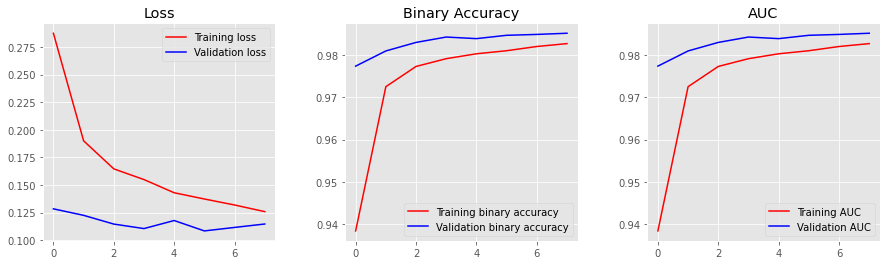

In [ ]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(15, 4))

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
acc = history.history['auc']
val_acc = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.subplot(1,3,1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Loss')
plt.legend(loc=0)

plt.subplot(1,3,2)
plt.plot(epochs, acc, 'r', label='Training binary accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation binary accuracy')
plt.title('Binary Accuracy')
plt.legend(loc=0)


plt.subplot(1,3,3)
plt.plot(epochs, acc, 'r', label='Training AUC')
plt.plot(epochs, val_acc, 'b', label='Validation AUC')
plt.title('AUC')
plt.legend(loc=0)

plt.subplots_adjust(wspace=0.3)
plt.show()

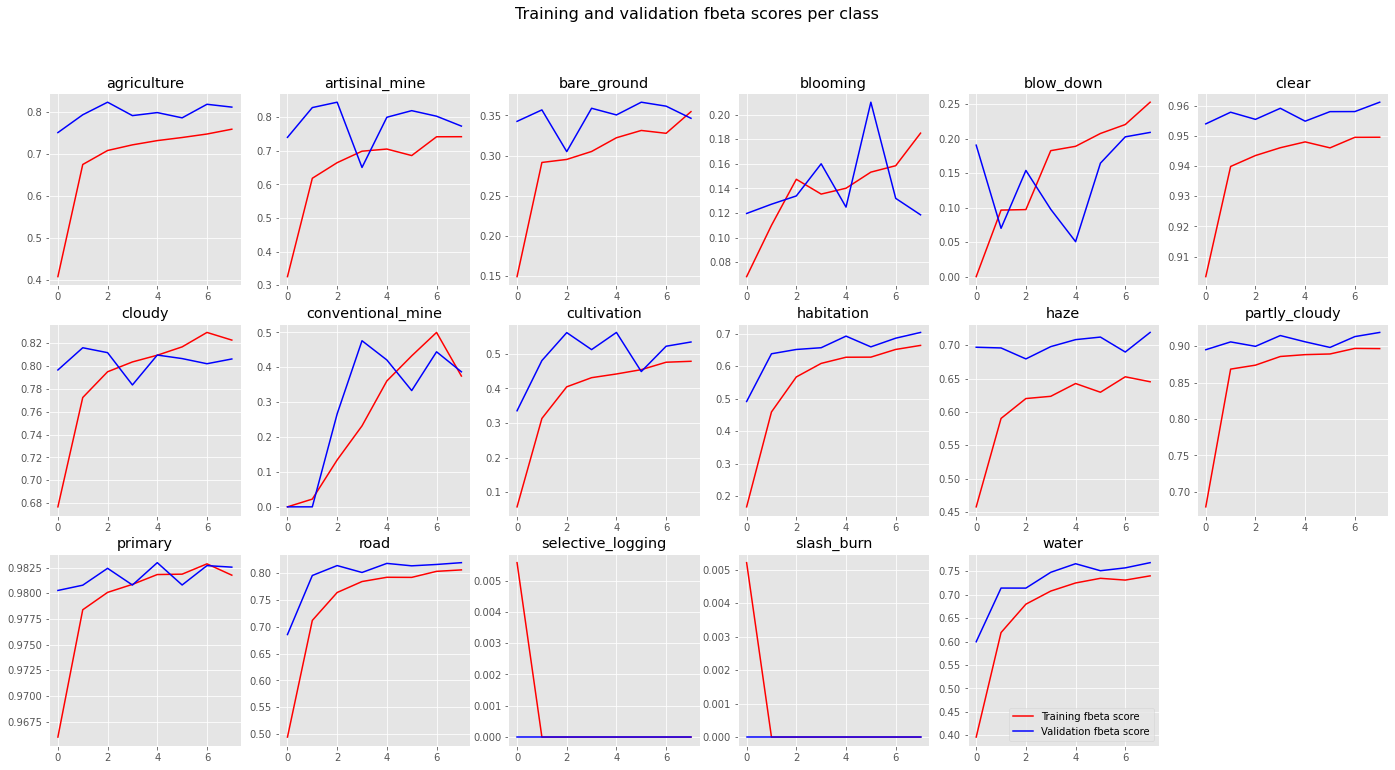

In [ ]:
fig = plt.figure(figsize=(24, 12))

def plot_fbeta(class_name, rows, cols):
  i = valid_generator.class_indices[class_name]
  plt.subplot(rows,cols,i+1)

  acc = np.array(history.history['fbeta_score'])[:,i]
  val_acc = np.array(history.history['val_fbeta_score'])[:,i]
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training fbeta score')
  plt.plot(epochs, val_acc, 'b', label='Validation fbeta score')
  plt.title(class_name)

for c in valid_generator.class_indices.keys():
  plot_fbeta(c, 3, 6)

plt.suptitle('Training and validation fbeta scores per class', fontsize=16)
plt.legend()
plt.show()

fbeta score can be misleading in imbalanced datasets or when measured in batches(stateless) rather than the entire dataset(stateful/global)

In [ ]:
#tf.keras.backend.clear_session()
#train_generator.reset()
#valid_generator.reset()

# MODEL EVALUATION

In [ ]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import classification_report

In [ ]:
#arbitrary use of validation data as test data

valid_generator.reset()      #re-using generator, so need to reset to avoid output being in a strange order

pred = model.predict(valid_generator, verbose=1)

threshold_bool = (pred > 0.5)

203/203 [==============================] - 42s 190ms/step


In [ ]:
print(pred.shape)
print(pred[:1])
y_pred = threshold_bool.astype(int)   
print(y_pred[:1])

(6479, 17)
[[8.6461883e-03 3.3334902e-05 2.7110220e-03 8.9868787e-05 1.5477792e-05
  2.8586251e-04 8.2996516e-03 7.8741768e-06 3.4009444e-03 4.0878329e-04
  2.1825665e-01 8.0616456e-01 9.8742348e-01 3.0817783e-03 3.6615442e-05
  1.0655438e-05 7.3316847e-03]]
[[0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0]]


In [ ]:
print(valid_generator.classes[:5])

[[0, 5, 8, 12], [0, 5, 8, 12, 16], [0, 5, 8, 12], [5, 12], [0, 11, 12, 13]]


In [ ]:
#print(valid_generator.class_indices)      #print for reference

In [ ]:
y_true = []     #OHE labels

for filename, tags in labels_df.values[split:]:   
  vector = np.zeros(len(label_set))   
  for tag in tags.split(' '):
    vector[valid_generator.class_indices[tag]] = 1
  y_true.append(vector)

y_true = np.array(y_true, dtype=np.int32)
print('y_true sample: ', '\n', y_true[:5])
print('y_pred sample: ', '\n', y_pred[:5])

y_true sample:  
 [[1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1]
 [1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0]]
y_pred sample:  
 [[0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]]


In [ ]:
print(y_true.shape)
print(y_pred.shape)

(6479, 17)
(6479, 17)


In [ ]:
# multilabel confusion matrix

cm = tfa.metrics.MultiLabelConfusionMatrix(num_classes=num_classes)     #(0,0): true negative, (0,1): false positive, (1,0): false negative, (1,1): true positive 
cm.update_state(y_true, y_pred)
result = cm.result()
print('confusion matrixes: ', '\n', result)

confusion matrixes:  
 tf.Tensor(
[[[3.234e+03 1.246e+03]
  [1.423e+03 5.760e+02]]

 [[6.343e+03 7.900e+01]
  [5.600e+01 1.000e+00]]

 [[6.153e+03 1.610e+02]
  [1.610e+02 4.000e+00]]

 [[5.807e+03 6.240e+02]
  [4.300e+01 5.000e+00]]

 [[6.412e+03 5.100e+01]
  [1.600e+01 0.000e+00]]

 [[6.030e+02 1.323e+03]
  [1.399e+03 3.154e+03]]

 [[5.850e+03 3.210e+02]
  [2.870e+02 2.100e+01]]

 [[6.448e+03 1.900e+01]
  [1.200e+01 0.000e+00]]

 [[5.381e+03 3.800e+02]
  [6.690e+02 4.900e+01]]

 [[5.371e+03 5.420e+02]
  [5.150e+02 5.100e+01]]

 [[5.655e+03 3.970e+02]
  [3.940e+02 3.300e+01]]

 [[4.317e+03 9.710e+02]
  [9.650e+02 2.260e+02]]

 [[2.800e+01 4.240e+02]
  [3.570e+02 5.670e+03]]

 [[4.065e+03 1.129e+03]
  [1.051e+03 2.340e+02]]

 [[6.424e+03 0.000e+00]
  [5.500e+01 0.000e+00]]

 [[6.440e+03 0.000e+00]
  [3.900e+01 0.000e+00]]

 [[4.592e+03 7.460e+02]
  [9.780e+02 1.630e+02]]], shape=(17, 2, 2), dtype=float32)


In [ ]:
# transpose
result = np.array(result, dtype=np.float32)     
result = [np.transpose(cm) for cm in result]     

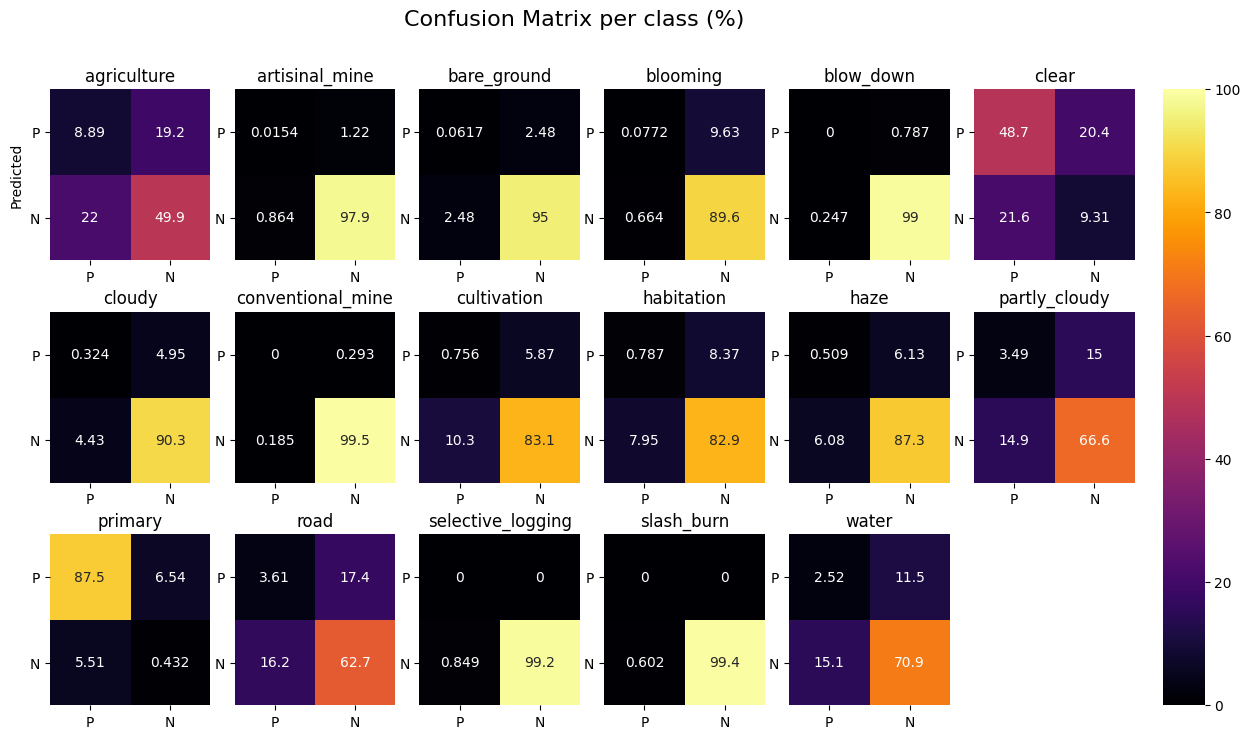

In [ ]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(14,8))

cbar_ax = fig.add_axes([.92, .11, .03, .77])

def plot_cm(i, class_name, cm, rows, cols):
  plt.subplot(rows,cols,i+1)
  ax = sns.heatmap(cm*100/6479, xticklabels=['N','P'], yticklabels=['N','P'], annot = True, fmt='.3g', vmin=0, vmax=100, cmap = 'inferno', cbar= (True if i==16 else False), cbar_ax=cbar_ax)
  ax.invert_xaxis()
  ax.invert_yaxis()
  plt.yticks(rotation=0)       #was changed from default earlier
  plt.title(class_name)
  if i==0:
    plt.ylabel('Predicted')

inverse = {i:k for i,k in enumerate(valid_generator.class_indices)}
for i,cm in enumerate(result):
  class_name = inverse[i]
  plot_cm(i, class_name, cm, 3, 6)

plt.suptitle('Confusion Matrix per class (%)', fontsize=16)
plt.subplots_adjust(wspace=0.15, hspace=0.3)
plt.show()

In [ ]:
print(fbeta_score(y_true, y_pred, average='weighted', beta=1.0))      

0.5495435725639818


In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.31      0.37      0.34      1999
           1       0.01      0.02      0.01        57
           2       0.02      0.07      0.04       165
           3       0.01      0.17      0.02        48
           4       0.00      0.00      0.00        16
           5       0.70      0.72      0.71      4553
           6       0.06      0.08      0.07       308
           7       0.00      0.00      0.00        12
           8       0.11      0.15      0.13       718
           9       0.07      0.12      0.09       566
          10       0.08      0.12      0.09       427
          11       0.19      0.20      0.20      1191
          12       0.93      0.96      0.94      6027
          13       0.17      0.23      0.20      1285
          14       0.08      0.02      0.03        55
          15       0.00      0.00      0.00        39
          16       0.18      0.20      0.19      1141

   micro avg       0.49   

Potential updates:
 - include supervised dim reduction, eg. LDA (linear)
 - explore libraries that allow plotting images onto 3d space or display image on mousehover


 - compute optimal thresholds per class
 - other methods of addressing class imbalance: 
   - can try class mode 'sparse'
   - can try 'sample_weight' in tf api instead of 'class_weight' 
   - can try custom weighted binary_cross entropy loss function, multi-label-classification-with-class-weights-in-keras
 - can try macro soft f1 loss, eliminates the need to optimize threshold value after training: https://towardsdatascience.com/multi-label-image-classification-in-tensorflow-2-0-7d4cf8a4bc72
 - further explore metrics for multi-label classification 


 - explore further options for preprocessing images: haze removal, contrast enhancement, image segmentation
 - adjust dataset: inspect outliers/maximally dissimilar images, eg. artifacts


 - explore computed parameter optimization: tf tuner, optuna, (bayesian optimization)
 - explore ensemble networks, allows selecting the most successful model for each label  
 - explore ridge regression, adds reguarlization penalty to loss function, reduces issues of multicollinearity, adjusts output to take advantage of label correlations (does not do variable selection)
 - try differing learnings rates for each individual layer in transfer learning
 - can try train atmospheric and land usage/cover classes seperately